# 本筆記內容：利用批次梯度下降法(Mini-batch Gradient Descent)實作線性迴歸。

我們希望讀者能透過此範例，來理解監督式機器學習的基本概念，包含：
   * 監督式機器學習即是最小化Loss函數。此範例中，Loss函數為Mean squared error。
   * 如何利用Mini-batch Gradient Descent更新權重。
   * L1(Lasso)的功用。
---
   
# 索引
[1.定義資料載入以及權重更新函數](#1.-定義資料載入以及權重更新函數)

[2. 定義專門用來處理線性迴歸的類別](#2.-定義專門用來處理線性迴歸的類別)

[3. 準備測試資料](#3.-準備測試資料)

[4. 開始對資料做線性回歸](#4.-開始對資料做線性回歸)

[5. 改變C, 由10000至10, 看回歸結果如何變化](#5.-改變C,-由10000至10,-看回歸結果如何變化)
  * [5.a. 將回歸結果繪圖](#5.a.-將回歸結果繪圖)
  * [5.b. 將權重繪圖](#5.b.-將權重繪圖)
---

In [1]:
from autograd import grad
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pandas as pd

## 1. 定義資料載入以及權重更新函數

In [2]:
def dataLoader(x,y,batch_size,shuffle=True):
    '''此函數負責批次性的拋出資料(資料的量為batch_size)給機器學習的演算法做訓練。'''
    
    num_batches=y.shape[0]//batch_size
    data=np.hstack((x,y.reshape(-1,1)))
    
    if shuffle==True:
        np.random.shuffle(data)
    for j in range(num_batches):
        x_batch= data[batch_size*j:batch_size*(j+1),0:x.shape[1]]
        y_batch= data[batch_size*j:batch_size*(j+1),x.shape[1]]
        yield x_batch,y_batch

def SGD(weights,weights_grads,lr=0.01):
    '''此函數用來做權重更新(stochastic gradient descent)。'''
    
    weights-=lr*weights_grads
    return weights

[回索引](#索引)

## 2. 定義專門用來處理線性迴歸的類別

In [3]:
class LinearRegression(object):
    '''此類別處理線性回歸(+L1正規項)。'''
    
    def predict(self,weights,x):
        '''輸入x, 利用現有的回歸參數w[0],w[1],w[2]來預測y。'''
        
        y_pred=np.dot(x,weights[1:])+weights[0]
        return y_pred
    
    def leastSquareLoss(self,weights):
        '''此為最小平方法的Loss函數(添加L1規範項)。註：參數C越大，則規範項強度越小。'''
        
        y_pred=self.predict(weights,self.x_batch)
        loss=(1./2.)*np.mean( (self.y_batch-y_pred)**2 )
        loss+=(1/self.C)*np.sum(np.abs(weights[1:])) # the L1 term
        return loss

    def fit(self,x,y,weights,batch_size,C,num_epochs,lr=0.001,infoStep=1,verbose=True):
        '''以批次更新方式，尋找最適回歸參數。'''
        
        # 初始化參數和用來儲存batch的資料矩陣
        self.C=C
        self.x_batch=np.zeros((batch_size,x.shape[1]))
        self.y_batch=np.zeros(batch_size)
        
        # 得到Loss函數對weights偏微分的函數表示式 (L')
        gradLoss=grad(self.leastSquareLoss)

        # 開始更新weights, 以降低當前Loss
        for epoch in range(1,num_epochs+1):
            generator=dataLoader(x,y,batch_size,shuffle=False)
            for idx,(x_batch,y_batch) in enumerate(generator):
                self.x_batch=x_batch
                self.y_batch=y_batch
                
                if(epoch==1 and idx==0):
                    # 根據初始weights來得到當前Loss的值
                    print('initial loss=',self.leastSquareLoss(weights))
                
                # 得到 L'(weights)
                weights_grads=gradLoss(weights)
                # 以梯度下降法更新weights
                weights=SGD(weights,weights_grads,lr=lr)
            if(verbose==True and epoch%infoStep==0):
                loss=self.leastSquareLoss(weights)
                print('epoch %3i,'%epoch,'loss=',loss)
            elif (verbose==False and epoch==num_epochs):
                loss=self.leastSquareLoss(weights)
                print('epoch %3i,'%epoch,'loss=',loss)
        return weights,loss

[回索引](#索引)

## 3. 準備測試資料

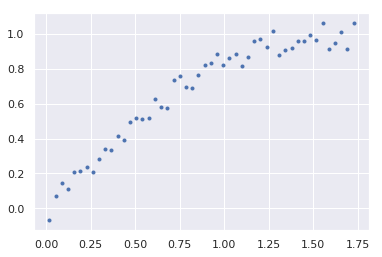

shape of x= (50, 4)
shape of y= (50,)


In [4]:
# 準備x,y
x = np.array([i*np.pi/180 for i in range(1,100,2)])
np.random.seed(100)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.05,len(x))
# 將x,y存成Pandas資料表型態
data = pd.DataFrame(np.column_stack([y,x]),columns=['y','x'])
plt.plot(data['x'],data['y'],'.')
plt.show()
# 準備x^2,x^3,x^4次方項
for i in range(2,5):
    colname = 'x_%d'%i
    data[colname] = data['x']**i
# 整理好資料後，將其存回Numpy矩陣
y=data.iloc[:,0].values
x=data.iloc[:,1:].values
data.head(3)
# 檢查x,y矩陣的形狀為何
print('shape of x=',x.shape)
print('shape of y=',y.shape)

[回索引](#索引)

## 4. 開始對資料做線性回歸

#### 4.a. L1規範項可忽略 

initial loss= 0.021255873792373363
epoch 100, loss= 0.0013895903208323388
epoch 200, loss= 0.0015969309420793593
epoch 300, loss= 0.0018768848976848211
epoch 400, loss= 0.002100478881617191
epoch 500, loss= 0.002249866962200726
epoch 600, loss= 0.002337460718857707
epoch 700, loss= 0.0023806135723578228
epoch 800, loss= 0.0023940065836156074
epoch 900, loss= 0.0023883352802029066
epoch 1000, loss= 0.002370877123590287

 final weights= [ 0.12553205  0.49201401  0.28938095  0.06922541 -0.14463689]


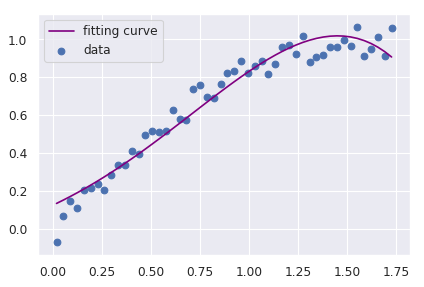

In [12]:
batch_size=10
num_epochs=1000
infoStep=100
lr=0.01
C=1000000000  # C非常大，L1規範項可忽略
verbose=True

regressor= LinearRegression()
weights= np.random.normal(0,0.01,x.shape[1]+1) # 初始化權重向量
weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                            lr=lr,infoStep=infoStep,verbose=verbose) # 回歸開始
print('\n final weights=',weights)
y_pred=regressor.predict(weights,x) # 以所學之權重向量，來預測所輸入的x其y值為何

plt.figure(dpi=80)
plt.scatter(x[:,0],y,label='data') # 繪製原始資料
plt.plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple') # 繪製回歸結果
plt.legend()
plt.show()

[回索引](#索引)

#### 4.b. 將C的數值減低，以增加L1規範項的影響

initial loss= 0.021175704414604313
epoch 100, loss= 0.010866800070317905
epoch 200, loss= 0.010817704513302783
epoch 300, loss= 0.011073758859333802
epoch 400, loss= 0.011240460283707458
epoch 500, loss= 0.011346131749277535
epoch 600, loss= 0.011412083108848645
epoch 700, loss= 0.011453841739977433
epoch 800, loss= 0.011473756804064483
epoch 900, loss= 0.011482246771333176
epoch 1000, loss= 0.011487893837465832

 final weights= [ 2.72484853e-01  3.84730228e-01  7.91526909e-02 -3.69200275e-04
 -1.31016682e-02]


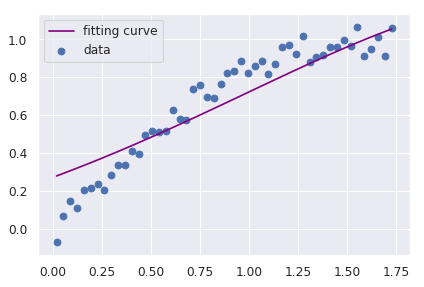

In [6]:
batch_size=10
num_epochs=1000
infoStep=100
lr=0.01
C=50  # C不是非常大，L1規範項不可忽略
verbose=True

regressor= LinearRegression()
weights= np.random.normal(0,0.01,x.shape[1]+1)
weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                            lr=lr,infoStep=infoStep,verbose=verbose)
print('\n final weights=',weights)
y_pred=regressor.predict(weights,x)

plt.figure(dpi=80,figsize=(6,4))
plt.scatter(x[:,0],y,label='data')
plt.plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple')
plt.legend()
plt.show()

[回索引](#索引)

## 5. 改變C, 由10000至10, 看回歸結果如何變化

In [7]:
info=[]
for C in np.logspace(4,1,6,dtype=np.int32):
    print('\n C=',C)
    batch_size=10
    num_epochs=3000
    infoStep=100
    lr=0.01
    verbose=False

    regressor= LinearRegression()
    weights= np.random.normal(0,0.01,x.shape[1]+1)
    weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                                lr=lr,infoStep=infoStep,verbose=verbose)
    y_pred=regressor.predict(weights,x)
    
    info.append([weights,loss,y_pred,C])


 C= 10000
initial loss= 0.022758154463962673
epoch 3000, loss= 0.0019387914544166031

 C= 2511
initial loss= 0.02273256088978146
epoch 3000, loss= 0.0022254465082714218

 C= 630
initial loss= 0.024508602911720072
epoch 3000, loss= 0.0032338954560467356

 C= 158
initial loss= 0.022234082282275778
epoch 3000, loss= 0.006390944473182239

 C= 39
initial loss= 0.02089570726448727
epoch 3000, loss= 0.013855380852075702

 C= 10
initial loss= 0.022364924928958238
epoch 3000, loss= 0.012720894333084922


[回索引](#索引)

#### 5.a. 將回歸結果繪圖

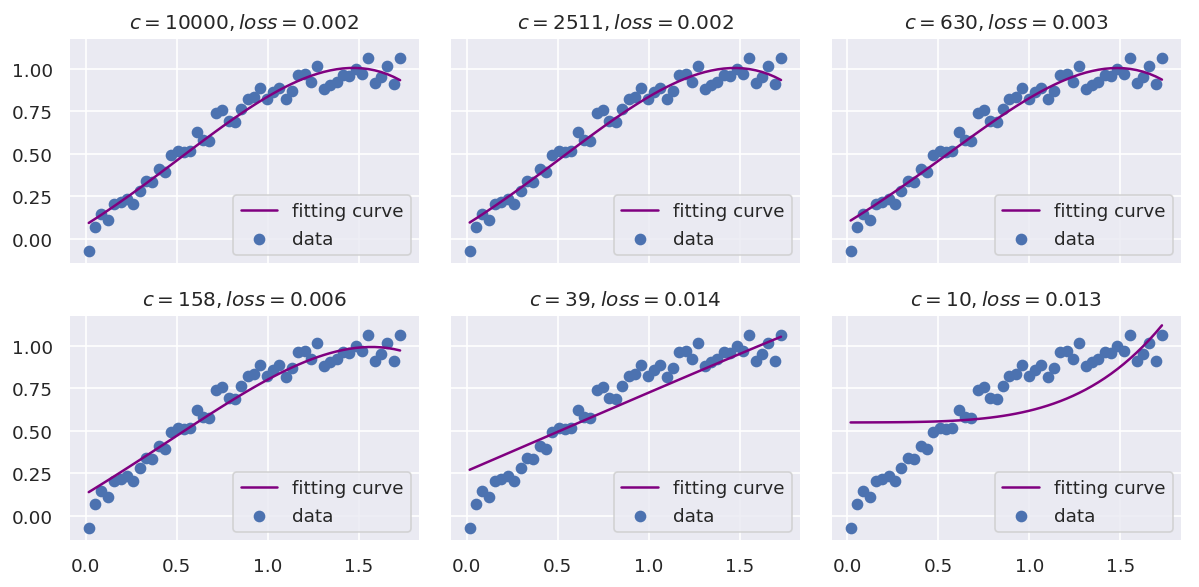

In [8]:
fig,axes=plt.subplots(2,3,sharey=True,sharex=True)
fig.set_size_inches(10,5)
fig.dpi=120
axes=axes.reshape(-1)
for idx,result in enumerate(info):
    
    weights=result[0]
    loss=result[1]
    y_pred=result[2]
    C=result[3]

    axes[idx].scatter(x[:,0],y,label='data')
    axes[idx].plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple')
    axes[idx].legend()
    axes[idx].set_title('$c=%i, loss=%.3f$'%(C,loss))
plt.tight_layout()

[回索引](#索引)

#### 5.b. 將權重繪圖

In [9]:
w=np.zeros((6,5))
c=np.zeros(6,dtype=np.int32)
for idx,result in enumerate(info):
    weights=result[0]
    C=result[3]
    w[idx,:]=weights
    c[idx]=C

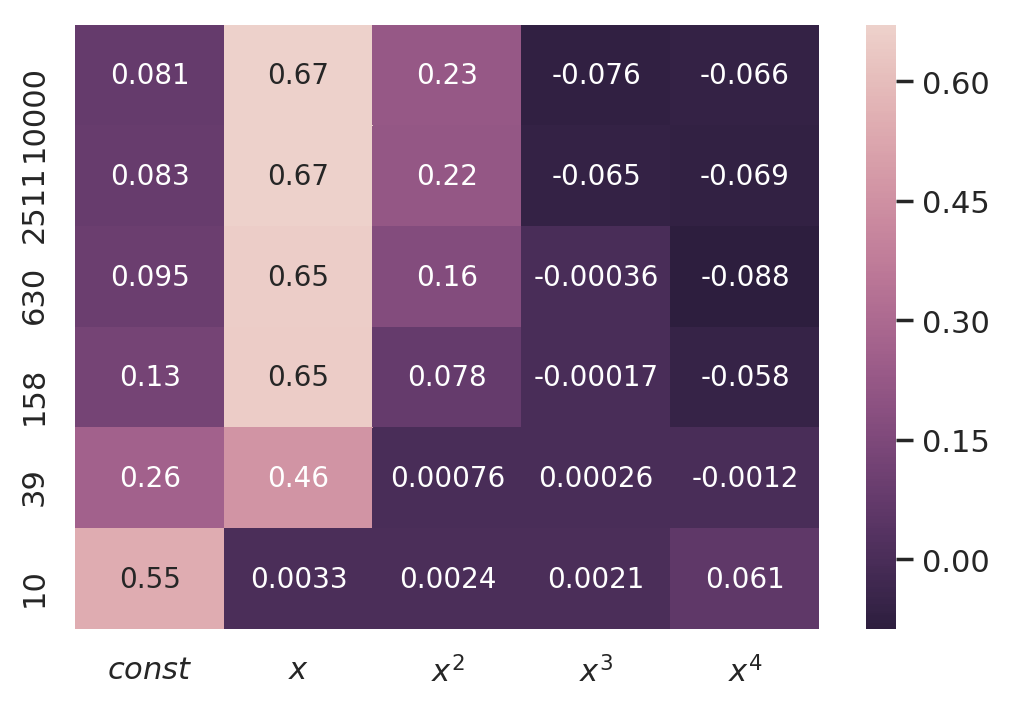

In [10]:
fig,ax=plt.subplots()
fig.set_dpi(200)

s=sns.cubehelix_palette(reverse=True,as_cmap=True)
sns.heatmap(w,xticklabels=['$const$','$x$','$x^2$','$x^3$','$x^4$']
             ,yticklabels=c,cmap=s,ax=ax,annot=True)
plt.show()

[回索引](#索引)